In [9]:
import gc
import shutil
import timm
import torch
import logging

import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.transforms import Lambda
from pathlib import Path
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from tqdm import tqdm, tqdm_notebook
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
# from torchvision.transforms import Compose
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize


In [10]:
# Global variables 
dataset_path = Path('/kaggle/input/donorsearchocr-dataset')
src_path = Path('/kaggle/working/')

img_path = src_path / 'images'
weights_path = src_path / 'davit_weights.pt'
labels_path = dataset_path / 'gt.json'
test_path = dataset_path / 'test'
val_path = dataset_path / 'val'
train_path = dataset_path / 'train'

if not torch.cuda.is_available():
    print('CUDA is not available.  Training on CPU ...')
    DEVICE = device = torch.device('cpu')
else:
    print('CUDA is available!  Training on GPU ...')
    DEVICE = device = torch.device('cuda')

random_state = 42
IMG_SIZE = rescale_size = 512
MODEL_NAME = model_name = 'davit_huge_fl'

m_logger = logging.getLogger(__name__)
m_logger.setLevel(logging.DEBUG)
handler_m = logging.StreamHandler()
formatter_m = logging.Formatter("%(name)s %(asctime)s %(levelname)s %(message)s")
handler_m.setFormatter(formatter_m)
m_logger.addHandler(handler_m)

CUDA is not available.  Training on CPU ...


In [11]:
#Reading dataset filenames with labels assigned

labels = pd.read_json(labels_path, typ='dictionary')

#Preparing train, val, test dataset samples 
labels_train_val, labels_test = train_test_split(labels, test_size=.1, stratify=labels, random_state=random_state)
labels_train, labels_val = train_test_split(labels_train_val, test_size=.2, stratify=labels_train_val, random_state=random_state)

In [5]:
# for img_file in labels_test.index:
#     shutil.copyfile(Path(img_path)/img_file, test_path/img_file)

# for img_file in labels_train.index:
#     shutil.copyfile(Path(img_path)/img_file, train_path/img_file)

# for img_file in labels_val.index:
#     shutil.copyfile(Path(img_path)/img_file, val_path/img_file)

In [12]:
#Creating common directory for all images (to calculate MEAN and CTD of the whole dataset)
%mkdir {img_path} 
!ln -s {train_path}/* {img_path}/
!ln -s {val_path}/* {img_path}/
!ln -s {test_path}/* {img_path}/

Анализ баланска классов:

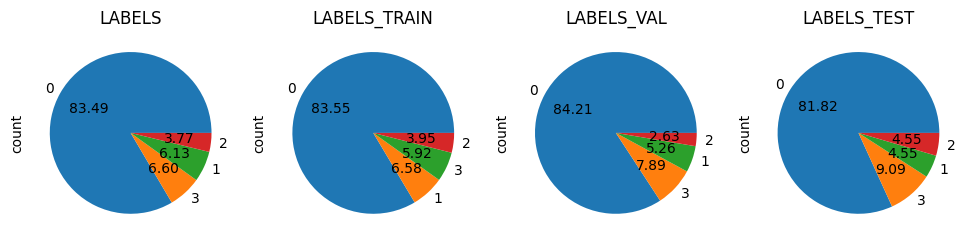

In [13]:
t = ['labels', 'labels_train', 'labels_val', 'labels_test']
l = [labels, labels_train, labels_val, labels_test]
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, ax in enumerate(axes.flatten()):
    l[i].value_counts().plot.pie(autopct='%.2f', ax=ax)
    ax.set_title(t[i].upper())

Определение класса датасета с обработкой изображений через библиотеку Albumentations:

In [6]:
class PrepareDataset(Dataset):
    """
    A Dataset class which performs scaling and tensorization of the loading images
    """
    def __init__(self, mode, labels_path=labels_path, mean=None, std=None):
        super().__init__()
        self.data_modes = set(['train', 'test', 'val', 'full'])
        self.all_labels = pd.read_json(labels_path, typ='dictionary')
        self.mode = mode
        if self.mode not in self.data_modes:
            print(f"{self.mode} is not correct; correct modes: {self.data_modes}")
            raise NameError
            
        if mode == 'train':
            self.img_path = train_path
        elif mode == 'val':
            self.img_path = val_path
        elif mode == 'test':
            self.img_path = test_path
        else:
            self.img_path = img_path
        
        self.files = sorted(list(p.resolve().name for p in self.img_path.glob("**/*") if p.suffix in {'.png', '.jpg', '.jpeg'}))
        self.labels = self.all_labels[self.files]
        self.len_ = len(self.files)

        # default ImageNet mean and std
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]

        #if not ImageNet
        if mean != None:
            self.mean = mean
        if std != None:
            self.std = std
                    
    def __len__(self):
        return self.len_

    def transform(self, image, label):
        """Function transforms input """
        w, h = image.shape[0], image.shape[1]
        max_wh = np.max([w, h])
        
        def random_rotate(image, label):
            """Randomly rotates image and changes its label accordingly"""
            quadrant = np.random.randint(4)
            angles = {0:0, 1:270, 2:180, 3:90}
            aug = A.Compose([A.PadIfNeeded(min_height=max_wh, min_width=max_wh, border_mode=0, value=(255, 255, 255)),
                             A.Affine(rotate=angles[quadrant], p=1)])
            image = aug(image=image)["image"]
            label = (label + quadrant) % 4
            return image, label
        
        if self.mode == 'train':
            image, label = random_rotate(image, label)
            aug = A.Compose([
                A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=5, border_mode=0, value=(255, 255, 255), p=0.2),
                A.OneOf([
                    A.Resize(rescale_size, rescale_size, p=0.7),
                    A.Sequential([
                        A.Resize(rescale_size, rescale_size),
                        A.RandomCrop(height=500, width=500),
                        A.Resize(rescale_size, rescale_size)
                    ], p=0.3),
                ], p=1),
                A.CoarseDropout(num_holes_range=(1, 4),
                                    hole_height_range=(30, 100),
                                    hole_width_range=(30, 100),
                                    fill_value=(255, 255, 255),
                                    p=0.333), 
                A.OneOf([ 
                    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1),
                                               contrast_limit=(-0.1, 0.1),
                                               p=0.5),
                    A.RGBShift(r_shift_limit=5, g_shift_limit=5, b_shift_limit=5, p=0.5),       
                ], p=1),
                A.OneOf([
                    A.GaussianBlur(blur_limit=(3,5), p=0.5),
                    A.ImageCompression(quality_lower=30, quality_upper=60, p=0.5)
                ], p=1),
                A.Normalize(
                    mean=self.mean,
                    std=self.std),
                ToTensorV2()
            ])

        elif self.mode == 'val' or self.mode == 'test':
            aug = A.Compose([
                  A.PadIfNeeded(min_height=max_wh, min_width=max_wh, border_mode=0, value=(255, 255, 255)),
                  A.Resize(rescale_size, rescale_size),
                  A.Normalize(
                     mean=self.mean,
                     std=self.std),
                 ToTensorV2()
            ])
        else:
            aug = A.Compose([
                  A.Resize(rescale_size, rescale_size),
                  A.Normalize(
                      mean=self.mean,
                      std=self.std),
                  ToTensorV2()
            ])
        return aug(image=image)['image'], label
      
    def load_sample(self, file):
        image = Image.open(self.img_path / file).convert('RGB')
        return np.array(image)
  
    def __getitem__(self, index):
        x = self.load_sample(self.files[index])
        y = self.labels.iloc[index]
        x, y = self.transform(x, y)
        return x, y
        

Подсчет значений среднего (MEAN) и ст. отклонения (STD) для всего датасета (для нормализации изображений)

In [14]:
full_dataset = PrepareDataset(mode='full')

transform = ToTensorV2()

# Initialize variables to store cumulative sum of pixel values
mean = torch.zeros(3)
var_temp = torch.zeros(3)

# Compute mean
num_samples = len(full_dataset)
for i in range(num_samples):
    image, _ = full_dataset[i]
    mean += torch.mean(image, dim=(1, 2))

mean /= num_samples
MEAN = mean

# Compute variance
for i in range(num_samples):
    image, _ = full_dataset[i]
    var_temp += torch.mean((image - mean.unsqueeze(1).unsqueeze(2))**2, dim=(1, 2))

# Compute standard deviation
std_dev = torch.sqrt(var_temp / num_samples)
STD = std_dev

print(f"Computed Mean of the dataset is: {mean}")
print(f"Computed Standard deviation of the dataset is: {std_dev}")

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Computed Mean of the dataset is: tensor([1.3638, 1.5033, 1.6996])
Computed Standard deviation of the dataset is: tensor([1.0195, 1.0658, 1.0899])


In [15]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std_dev * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)
    
def show_random_aug_files(dataset):
    """Outputs a sample of the 25 random images on the grid """
    fig, ax = plt.subplots(nrows=5,ncols=5, figsize=(20, 20),sharey=True, sharex=True)
    for figure in ax.flatten():
        random_img_ind = np.random.randint(0, len(dataset))
        im, label = dataset[random_img_ind]
        imshow(im.data.cpu(), title=label, plt_ax=figure)
    

Аугментированный тренировочный датасет выглядит так:

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


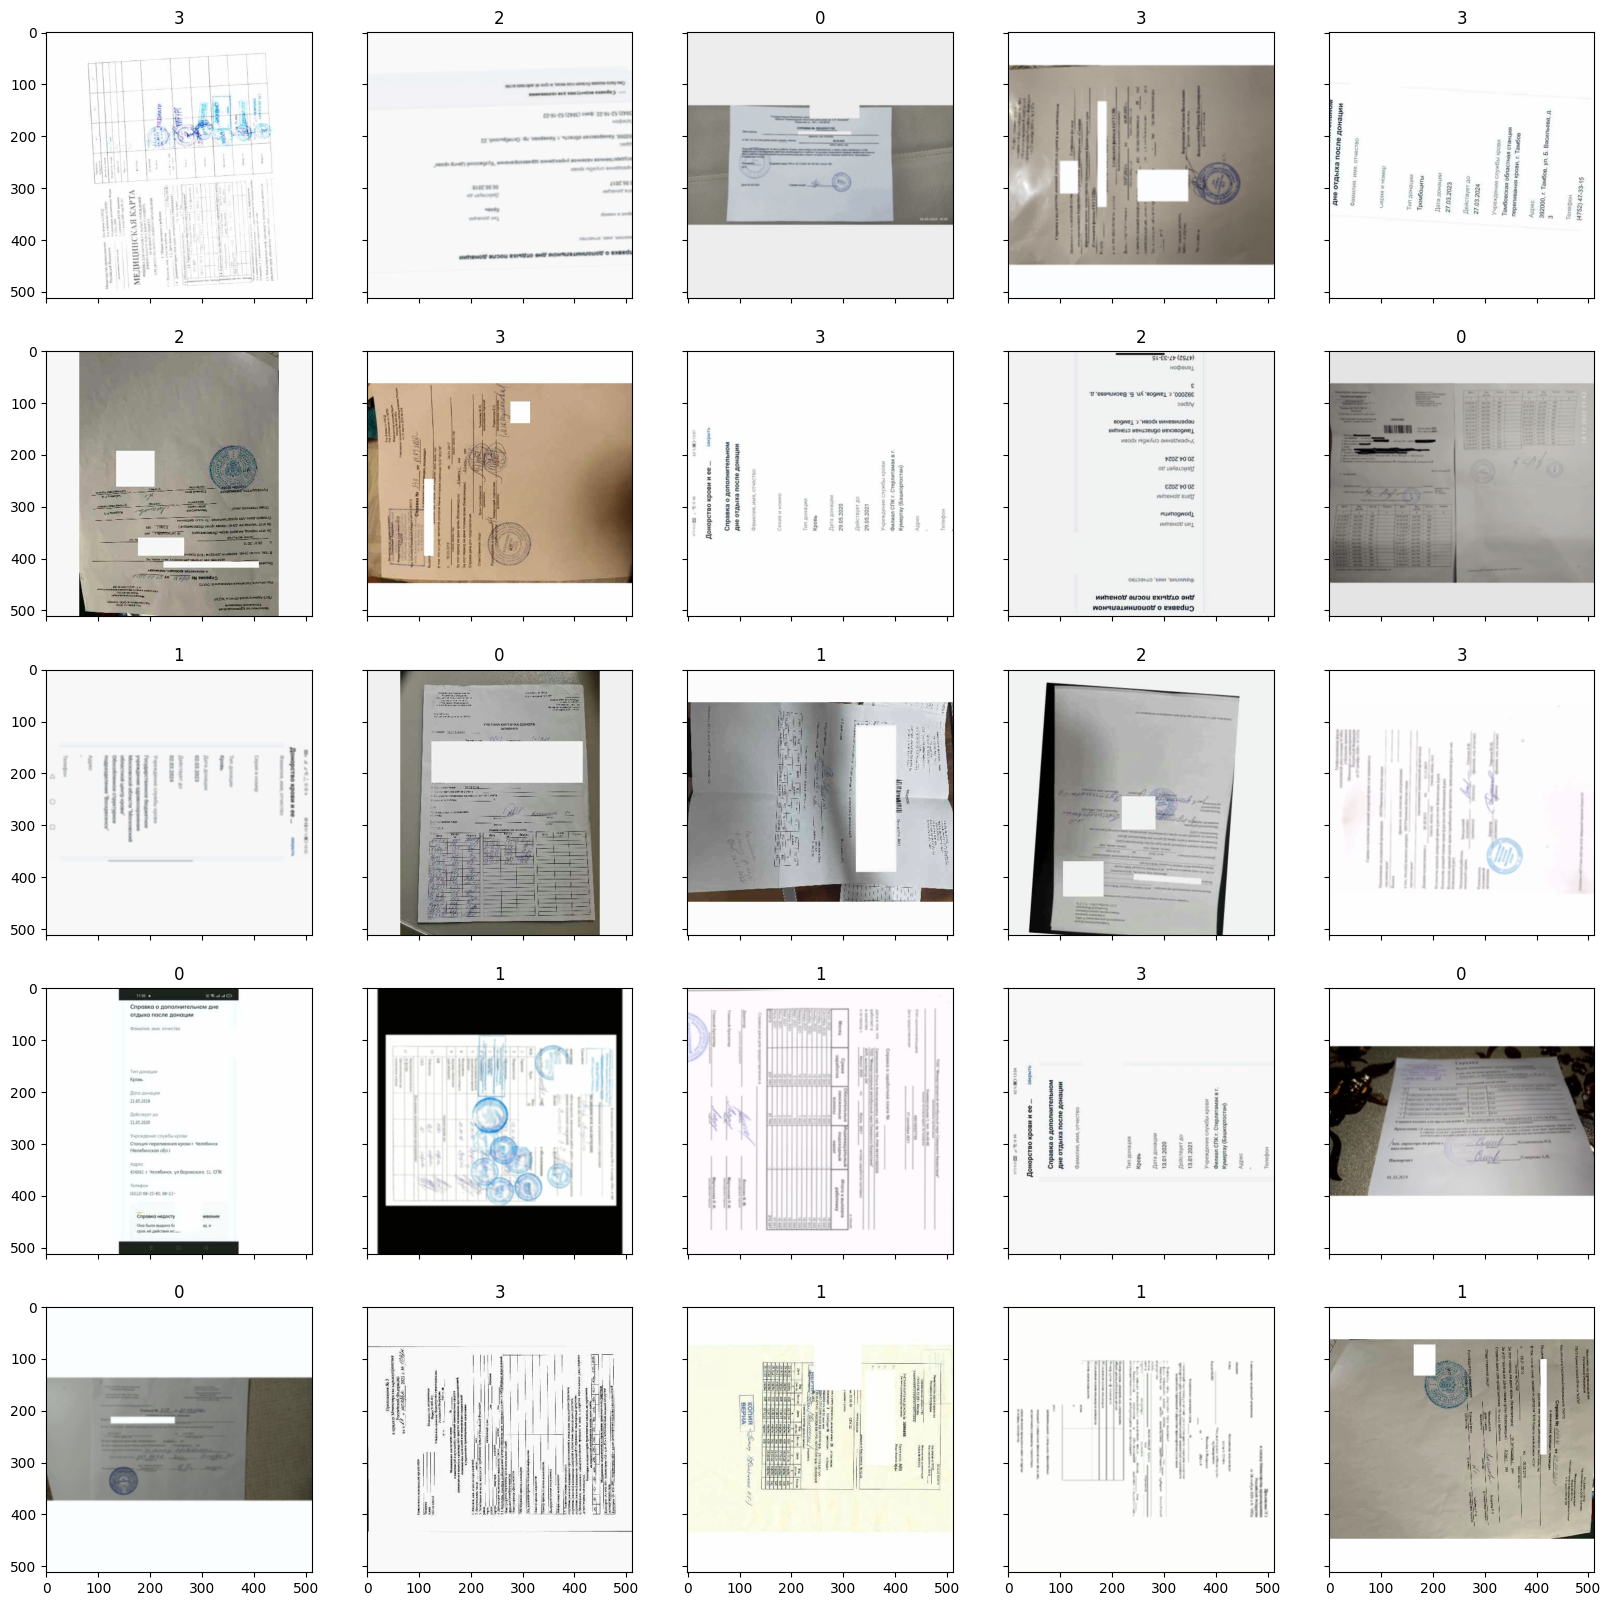

In [22]:
train_dataset = PrepareDataset(mode='train', mean=mean.tolist(), std=std_dev.tolist())
show_random_aug_files(train_dataset)

Загрузка модели на архитектуре визуального трансформера ([Dual Attention Visual Transformers](https://arxiv.org/abs/2204.03645) )

In [45]:
model = timm.create_model(model_name, pretrained=True, num_classes=4)

pytorch_model.bin:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/timm/models/_hub.py:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cached_file, map_location='cpu')


Оставляем только последние слои для обучения (производим transfer learning): 

In [46]:
for name, param in model.named_parameters():
    if name.startswith(('head', 'stages.3')):
        param.requires_grad = True
    else:
        param.requires_grad = False

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

stages.3.downsample.norm.weight
stages.3.downsample.norm.bias
stages.3.downsample.conv.weight
stages.3.downsample.conv.bias
stages.3.blocks.0.spatial_block.cpe1.proj.weight
stages.3.blocks.0.spatial_block.cpe1.proj.bias
stages.3.blocks.0.spatial_block.norm1.weight
stages.3.blocks.0.spatial_block.norm1.bias
stages.3.blocks.0.spatial_block.attn.qkv.weight
stages.3.blocks.0.spatial_block.attn.qkv.bias
stages.3.blocks.0.spatial_block.attn.proj.weight
stages.3.blocks.0.spatial_block.attn.proj.bias
stages.3.blocks.0.spatial_block.cpe2.proj.weight
stages.3.blocks.0.spatial_block.cpe2.proj.bias
stages.3.blocks.0.spatial_block.norm2.weight
stages.3.blocks.0.spatial_block.norm2.bias
stages.3.blocks.0.spatial_block.mlp.fc1.weight
stages.3.blocks.0.spatial_block.mlp.fc1.bias
stages.3.blocks.0.spatial_block.mlp.fc2.weight
stages.3.blocks.0.spatial_block.mlp.fc2.bias
stages.3.blocks.0.channel_block.cpe1.proj.weight
stages.3.blocks.0.channel_block.cpe1.proj.bias
stages.3.blocks.0.channel_block.norm1.

In [8]:
# torch.save(model.state_dict(), '/home/panther/Documents/Deep Learning/Side Projects/DonorSearch OCR/davit-f_wts_init.pth')

С дисбалансом классов можно бороться по-разному. Было выбрано решение рандомизировать повороты изображений во время загрузки изображений тренировочной выборки как демонстрирующее более быструю сходимость, однако также было протестировано решение с балансировкой недопредставленных классов с помощью sampler-а.

In [10]:
# cls_weights = torch.from_numpy(
#     compute_class_weight('balanced', classes=np.array([0, 1, 2, 3]), y=labels)
# )

# weights = cls_weights[labels_train]
# sampler = WeightedRandomSampler(weights, len(labels_train), replacement=True)

In [16]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=20, min_delta=0.01):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().double() / processed_size
    return val_loss, val_acc

def train(train_set, val_set, model, epochs, batch_size, lr=0.0001):
    # - для тренировки без рандомизации поворотов, но с балансированием классов через sampler
    #  train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler) 
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    save_path = weights_path
    best_val_acc = 0 
    best_val_loss = 999
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f} lr {l_r:0.7f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        params = list(model.stages[3].parameters())+list(model.head.parameters())
        optimizer = torch.optim.AdamW(params, lr=lr, amsgrad=True) # 
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                               patience=5,
                                                               threshold=0.01,
                                                               threshold_mode='abs') # scheduler decreasing lr on the loss plateau
        criterion = torch.nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            l_r =  [ group['lr'] for group in optimizer.param_groups ]
            history.append((train_loss, train_acc, val_loss, val_acc, l_r))
            pbar_outer.update(1)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_val_loss = val_loss
                save_checkpoint(model, optimizer, save_path, epoch)
            elif val_acc == best_val_acc:
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    save_checkpoint(model, optimizer, save_path, epoch)
              
            tqdm.write(log_template.format(ep=epoch+1,
                                           t_loss=train_loss,
                                           v_loss=val_loss,
                                           t_acc=train_acc,
                                           v_acc=val_acc,
                                           l_r=l_r[0]))
            early_stopping(train_loss)
            if early_stopping.early_stop:
                break

            scheduler.step(val_loss)
            
    return history

def predict(model, test_loader, test=True):
    def get_logits(inputs):
        inputs = inputs.to(device)
        model.eval()
        return model(inputs).cpu()
        
    with torch.no_grad():
        logits = []
        # if test:
        #     for inputs in test_loader:
        #         outputs = get_logits(inputs)
        #         logits.append(outputs)
        # else:
        for inputs, _ in test_loader:
            outputs = get_logits(inputs)
            logits.append(outputs)
            
    probs = torch.nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

def save_checkpoint(model, optimizer, save_path, epoch):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch
    }, save_path)

def load_checkpoint(model, optimizer, load_path):
    checkpoint = torch.load(load_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    
    return model, optimizer, epoch

def prepare_davit(model_name: str, params_path: str, num_classes: int, device: str):
    model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
    model = model.to(device)
    model.load_state_dict(torch.load(params_path, map_location=torch.device(device))['model_state_dict'])
#     m_logger.info(f'model loaded')
    return model



In [18]:
gc.collect()
torch.cuda.empty_cache()
early_stopping = EarlyStopping()
train_dataset = PrepareDataset(mode='train', mean=mean.tolist(), std=std_dev.tolist())
val_dataset = PrepareDataset(mode='val', mean=mean.tolist(), std=std_dev.tolist())
history = train(train_dataset, val_dataset, model=model.to(device), epochs=30, batch_size=32)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
epoch:   3%|▎         | 1/30 [00:58<25:03, 51.85s/it]


Epoch 001 train_loss: 2.5298     val_loss 1.4018 train_acc 0.2981 val_acc 0.1034 lr 0.0001000


epoch:   7%|▋         | 2/30 [02:00<27:03, 57.98s/it]


Epoch 002 train_loss: 1.0275     val_loss 0.1878 train_acc 0.5590 val_acc 0.9655 lr 0.0001000


epoch:  10%|█         | 3/30 [02:55<26:48, 59.59s/it]


Epoch 003 train_loss: 0.6972     val_loss 0.1238 train_acc 0.6708 val_acc 0.9310 lr 0.0001000


epoch:  13%|█▎        | 4/30 [03:50<25:03, 57.82s/it]


Epoch 004 train_loss: 0.4342     val_loss 0.3864 train_acc 0.7329 val_acc 0.8966 lr 0.0001000


epoch:  17%|█▋        | 5/30 [04:45<23:40, 56.81s/it]


Epoch 005 train_loss: 0.4514     val_loss 0.1590 train_acc 0.7950 val_acc 0.9310 lr 0.0001000
INFO: Early stopping counter 1 of 20


epoch:  20%|██        | 6/30 [05:40<22:29, 56.22s/it]


Epoch 006 train_loss: 0.3369     val_loss 0.1116 train_acc 0.8447 val_acc 0.9310 lr 0.0001000


epoch:  23%|██▎       | 7/30 [06:42<21:26, 55.93s/it]


Epoch 007 train_loss: 0.3109     val_loss 0.1130 train_acc 0.8820 val_acc 0.9655 lr 0.0001000


epoch:  27%|██▋       | 8/30 [07:44<21:14, 57.94s/it]


Epoch 008 train_loss: 0.4069     val_loss 0.0444 train_acc 0.8199 val_acc 1.0000 lr 0.0001000
INFO: Early stopping counter 2 of 20


epoch:  30%|███       | 9/30 [08:47<20:44, 59.26s/it]


Epoch 009 train_loss: 0.3041     val_loss 0.0199 train_acc 0.8509 val_acc 1.0000 lr 0.0001000
INFO: Early stopping counter 3 of 20


epoch:  33%|███▎      | 10/30 [09:49<20:02, 60.12s/it]


Epoch 010 train_loss: 0.2183     val_loss 0.0083 train_acc 0.9006 val_acc 1.0000 lr 0.0001000


epoch:  37%|███▋      | 11/30 [10:51<19:14, 60.76s/it]


Epoch 011 train_loss: 0.1513     val_loss 0.0048 train_acc 0.9130 val_acc 1.0000 lr 0.0001000


epoch:  40%|████      | 12/30 [11:47<18:21, 61.19s/it]


Epoch 012 train_loss: 0.2148     val_loss 0.1758 train_acc 0.9006 val_acc 0.8966 lr 0.0001000
INFO: Early stopping counter 4 of 20


epoch:  43%|████▎     | 13/30 [12:41<16:47, 59.28s/it]


Epoch 013 train_loss: 0.5637     val_loss 0.0119 train_acc 0.8323 val_acc 1.0000 lr 0.0001000
INFO: Early stopping counter 5 of 20


epoch:  47%|████▋     | 14/30 [13:37<15:28, 58.03s/it]


Epoch 014 train_loss: 0.4179     val_loss 0.0857 train_acc 0.8385 val_acc 0.9655 lr 0.0001000
INFO: Early stopping counter 6 of 20


epoch:  50%|█████     | 15/30 [14:32<14:17, 57.19s/it]


Epoch 015 train_loss: 0.2673     val_loss 0.0292 train_acc 0.8696 val_acc 1.0000 lr 0.0001000
INFO: Early stopping counter 7 of 20


epoch:  53%|█████▎    | 16/30 [15:27<13:12, 56.63s/it]


Epoch 016 train_loss: 0.1153     val_loss 0.0187 train_acc 0.9627 val_acc 1.0000 lr 0.0001000


epoch:  57%|█████▋    | 17/30 [16:22<12:11, 56.24s/it]


Epoch 017 train_loss: 0.1186     val_loss 0.0141 train_acc 0.9627 val_acc 1.0000 lr 0.0000100
INFO: Early stopping counter 8 of 20


epoch:  60%|██████    | 18/30 [17:18<11:10, 55.92s/it]


Epoch 018 train_loss: 0.0570     val_loss 0.0115 train_acc 1.0000 val_acc 1.0000 lr 0.0000100


epoch:  63%|██████▎   | 19/30 [18:13<10:13, 55.74s/it]


Epoch 019 train_loss: 0.0548     val_loss 0.0096 train_acc 0.9876 val_acc 1.0000 lr 0.0000100
INFO: Early stopping counter 9 of 20


epoch:  67%|██████▋   | 20/30 [19:08<09:16, 55.65s/it]


Epoch 020 train_loss: 0.1211     val_loss 0.0083 train_acc 0.9689 val_acc 1.0000 lr 0.0000100
INFO: Early stopping counter 10 of 20


epoch:  70%|███████   | 21/30 [20:04<08:19, 55.55s/it]


Epoch 021 train_loss: 0.0547     val_loss 0.0075 train_acc 0.9876 val_acc 1.0000 lr 0.0000100
INFO: Early stopping counter 11 of 20


epoch:  73%|███████▎  | 22/30 [20:59<07:24, 55.51s/it]


Epoch 022 train_loss: 0.0439     val_loss 0.0072 train_acc 1.0000 val_acc 1.0000 lr 0.0000100


epoch:  77%|███████▋  | 23/30 [21:54<06:27, 55.43s/it]


Epoch 023 train_loss: 0.0821     val_loss 0.0071 train_acc 0.9814 val_acc 1.0000 lr 0.0000010
INFO: Early stopping counter 12 of 20


epoch:  80%|████████  | 24/30 [22:50<05:32, 55.38s/it]


Epoch 024 train_loss: 0.0729     val_loss 0.0070 train_acc 0.9689 val_acc 1.0000 lr 0.0000010
INFO: Early stopping counter 13 of 20


epoch:  83%|████████▎ | 25/30 [23:45<04:36, 55.39s/it]


Epoch 025 train_loss: 0.0430     val_loss 0.0069 train_acc 0.9938 val_acc 1.0000 lr 0.0000010
INFO: Early stopping counter 14 of 20


epoch:  87%|████████▋ | 26/30 [24:40<03:41, 55.30s/it]


Epoch 026 train_loss: 0.0653     val_loss 0.0069 train_acc 0.9752 val_acc 1.0000 lr 0.0000010
INFO: Early stopping counter 15 of 20


epoch:  90%|█████████ | 27/30 [25:35<02:45, 55.29s/it]


Epoch 027 train_loss: 0.0812     val_loss 0.0067 train_acc 0.9689 val_acc 1.0000 lr 0.0000010
INFO: Early stopping counter 16 of 20


epoch:  93%|█████████▎| 28/30 [26:31<01:50, 55.26s/it]


Epoch 028 train_loss: 0.0639     val_loss 0.0066 train_acc 0.9752 val_acc 1.0000 lr 0.0000010
INFO: Early stopping counter 17 of 20


epoch:  97%|█████████▋| 29/30 [27:26<00:55, 55.26s/it]


Epoch 029 train_loss: 0.0749     val_loss 0.0066 train_acc 0.9627 val_acc 1.0000 lr 0.0000001
INFO: Early stopping counter 18 of 20


epoch: 100%|██████████| 30/30 [28:21<00:00, 56.72s/it]


Epoch 030 train_loss: 0.0556     val_loss 0.0066 train_acc 0.9876 val_acc 1.0000 lr 0.0000001
INFO: Early stopping counter 19 of 20


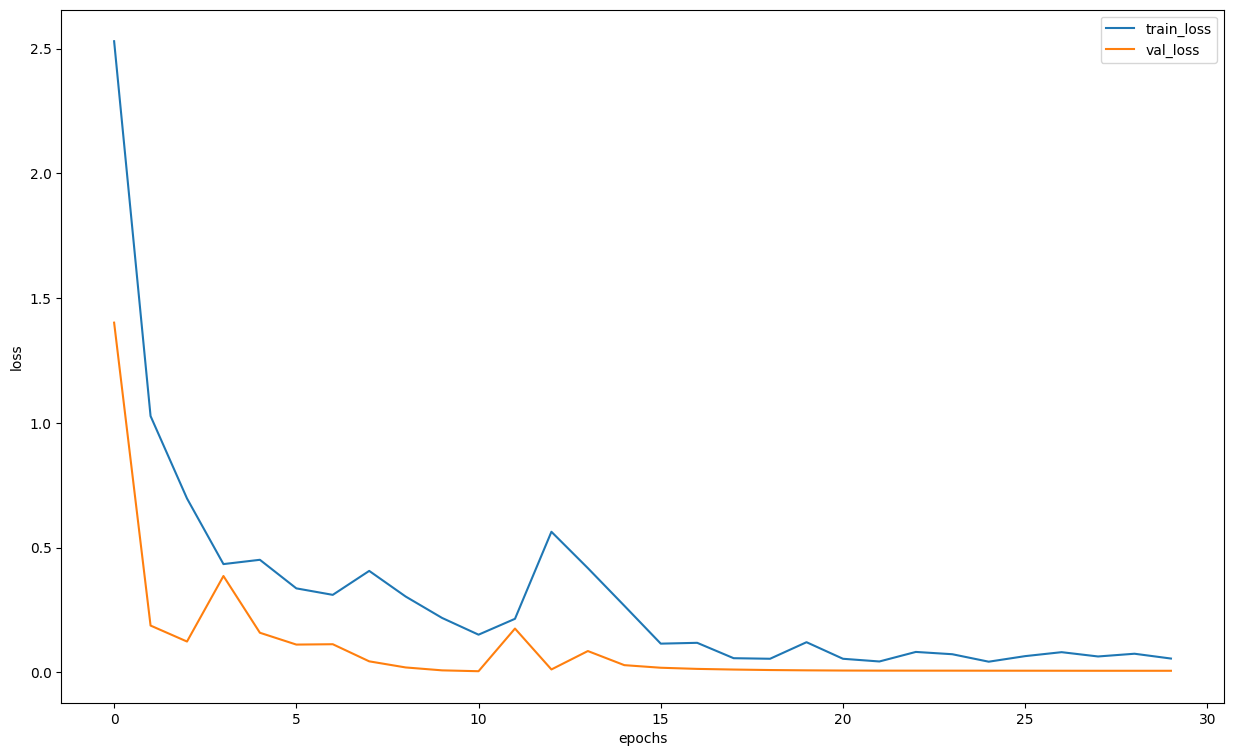

In [19]:
loss, acc, val_loss, val_acc, lr = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

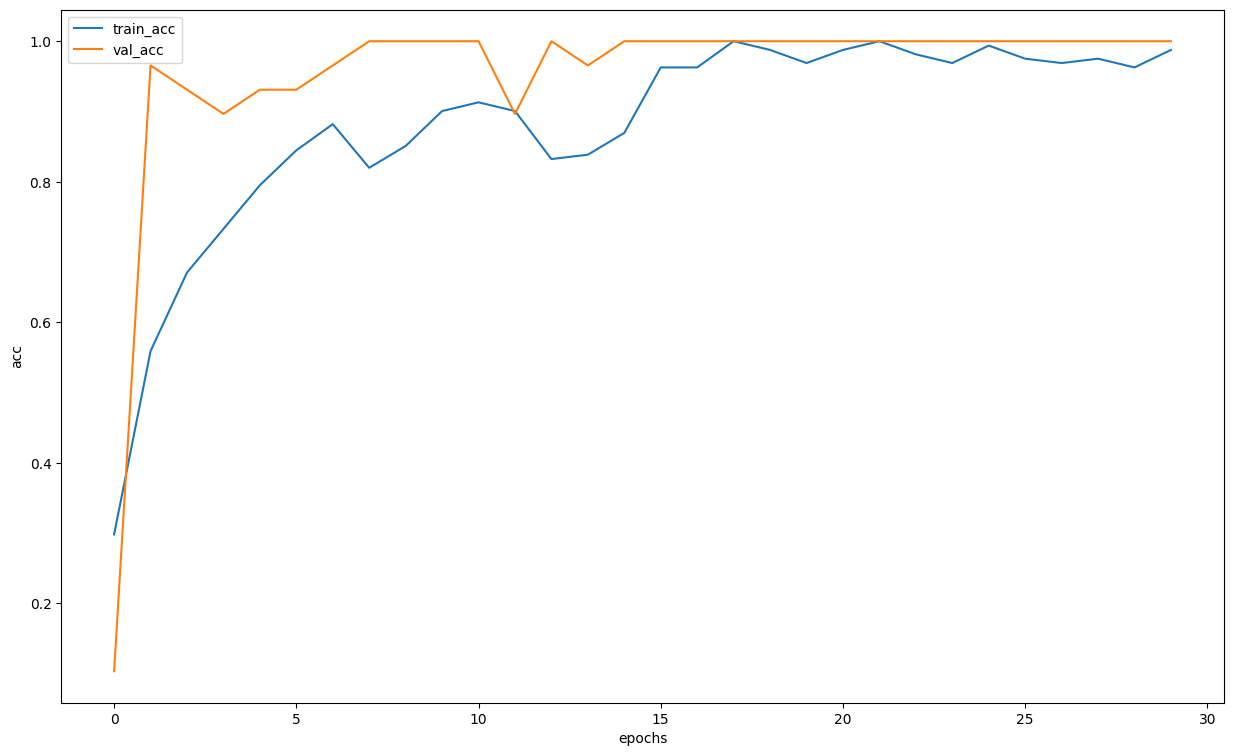

In [20]:
val_acc = [acc.cpu() for acc in val_acc]
plt.figure(figsize=(15, 9))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

In [24]:
model = prepare_davit(model_name, weights_path, 4, device)

/tmp/ipykernel_36/4216495956.py:166: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(params_path, map_location=torch.device(device))['model_st

In [18]:
val_dataset = PrepareDataset(mode='val', mean=mean.tolist(), std=std_dev.tolist())
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
val_probs = predict(model, val_loader)
val_preds = np.argmax(val_probs, axis=1)

In [26]:
f1_score(val_dataset.labels, val_preds, average='weighted')

1.0

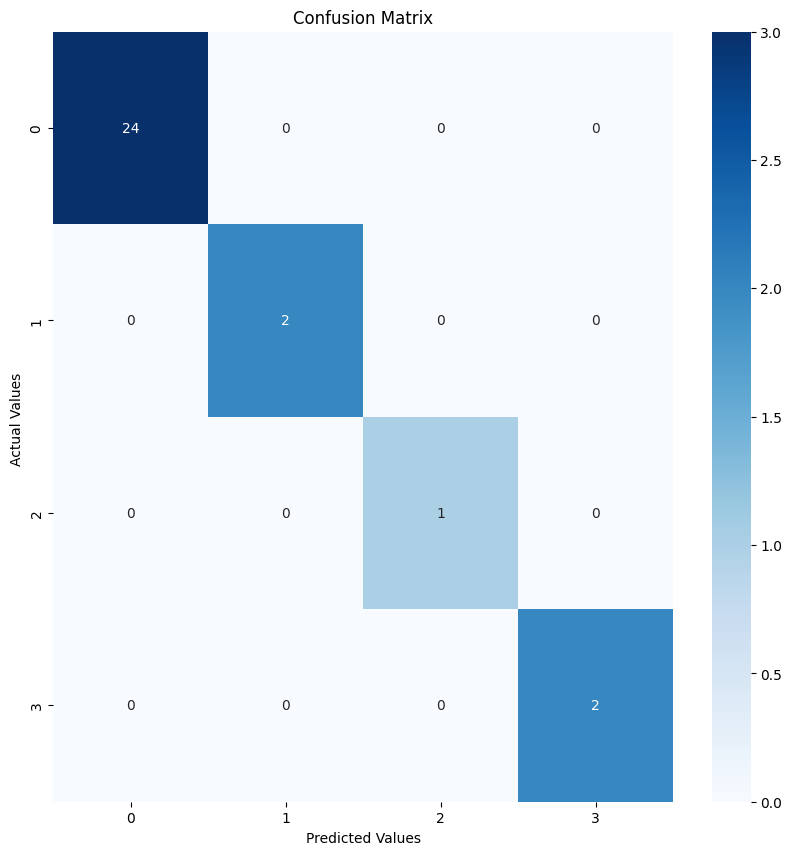

In [19]:
conf_mx = pd.DataFrame(confusion_matrix(val_preds, val_dataset.labels))
# conf_mx.style.background_gradient(cmap='Blues')

fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(conf_mx, annot=True, fmt="d", ax=ax, cmap="Blues", vmax=3)

ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels([0, 1, 2, 3])
ax.yaxis.set_ticklabels([0, 1, 2, 3])
plt.show()

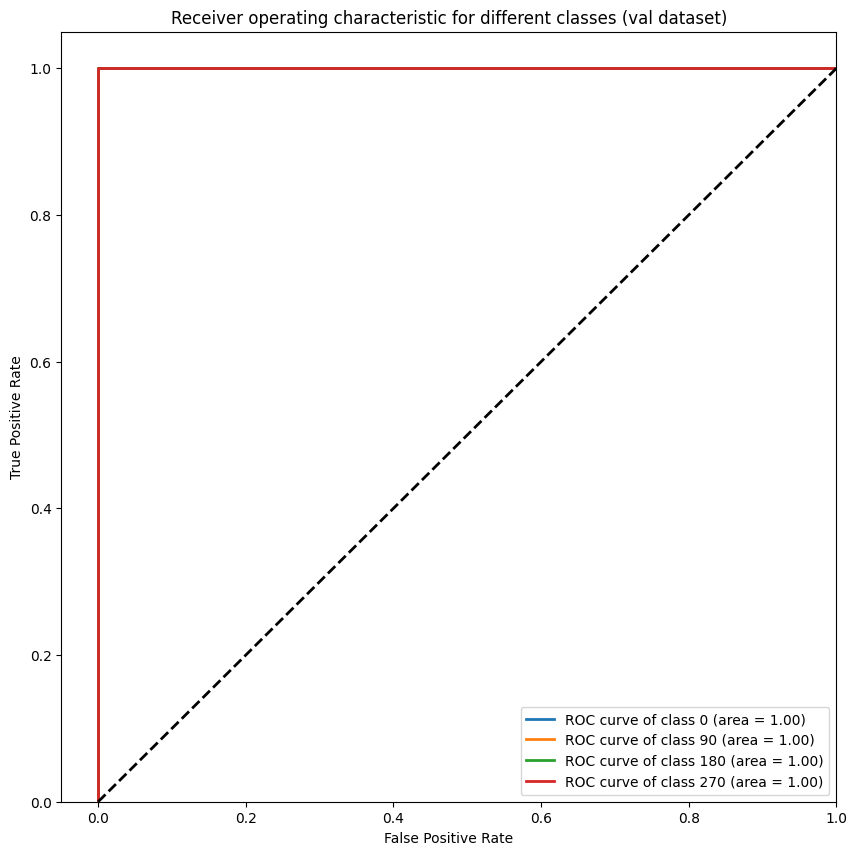

In [20]:
fig, ax = plt.subplots(figsize=(10,10))
fpr = dict()
tpr = dict()
roc_auc = dict()
classes = [0, 1, 2, 3]
labels = ['0', '90', '180', '270']
label_val = label_binarize(val_dataset.labels, classes=classes)
n_classes = label_val.shape[1]
y_score = val_probs

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(label_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for different classes (val dataset)')
plt.legend(loc="lower right")
plt.show()

In [21]:
test_dataset = PrepareDataset(mode='test', mean=mean.tolist(), std=std_dev.tolist())
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_probs = predict(model, test_loader)
test_preds = np.argmax(test_probs, axis=1)


In [25]:
f1_score(test_dataset.labels, test_preds, average='weighted')

0.9614718614718615

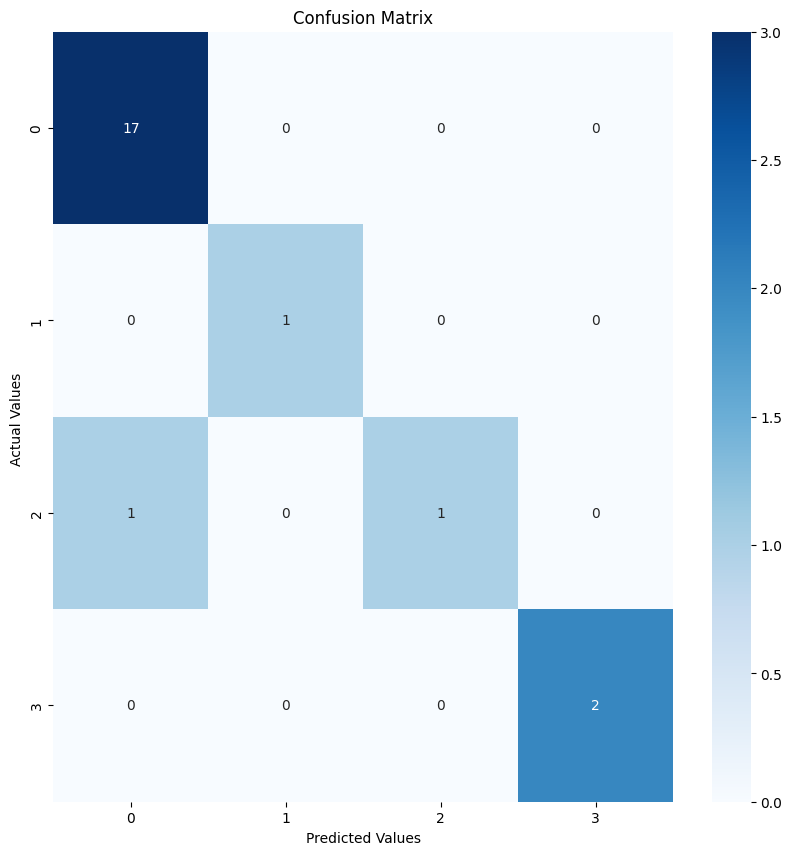

In [22]:
conf_mx = pd.DataFrame(confusion_matrix(test_preds, test_dataset.labels))
# conf_mx.style.background_gradient(cmap='Blues')
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(conf_mx, annot=True, fmt="d", ax=ax, cmap="Blues", vmax=3)

ax.set_title('Confusion Matrix');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels([0, 1, 2, 3])
ax.yaxis.set_ticklabels([0, 1, 2, 3])
plt.show()

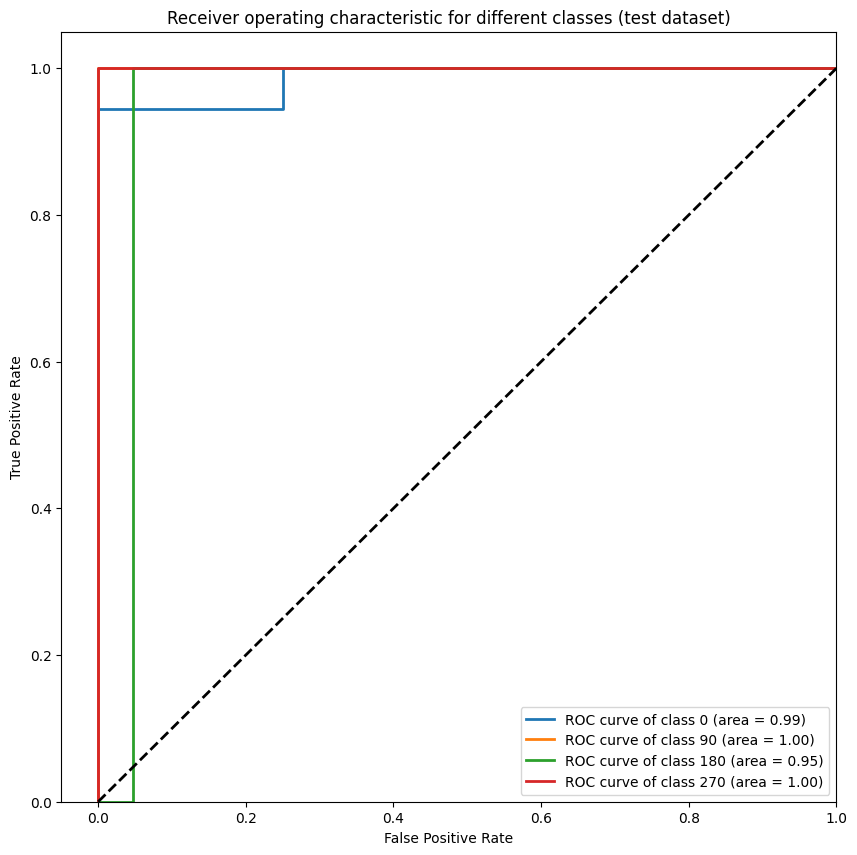

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
fpr = dict()
tpr = dict()
roc_auc = dict()
classes = [0, 1, 2, 3]
labels = ['0', '90', '180', '270']
label_test = label_binarize(test_dataset.labels, classes=classes)
n_classes = label_test.shape[1]
y_score = test_probs

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(label_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))


plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for different classes (test dataset)')
plt.legend(loc="lower right")
plt.show()

In [30]:
def evaluate_image(image_path, model, mean=MEAN, std=STD):
    """Per image evaluator, takes image path, augmentes it
    and returns it correctly rotated"""
    
    def transform_sample(image):
        """Transformation to math the ones during training"""
        w, h = image.shape[0], image.shape[1]
        max_wh = np.max([w, h])
        aug = A.Compose([
            A.PadIfNeeded(min_height=max_wh,
                          min_width=max_wh,
                          border_mode=0,
                          value=(255, 255, 255)),
            A.Resize(IMG_SIZE, IMG_SIZE),
            A.Normalize(
                mean=mean,
                std=std),
            ToTensorV2()
        ])
        return aug(image=image)['image']
    
    try:
        image = Image.open(image_path)
        img = np.array(image.convert('RGB'))
    except PIL.UnidentifiedImageError:
        m_logger.error(f'something wrong with image')
        status = 'Fail'
        return status, image_path
    angles = {0: 0, 1: 90, 2: 180, 3: 270}
    transformed_img = transform_sample(img).unsqueeze(dim=0)
    transformed_img = transformed_img.to(DEVICE)
    with torch.no_grad():
        model.eval()
        try:
            output = model(transformed_img)
            index = output.data.cpu().numpy().argmax()
            rotated_img = image.rotate(angles[index], expand=True)
            status = 'OK'
            m_logger.info(f'recognition completed')
        except:
            status = 'Fail'
            m_logger.info(f'recognition failed')
            return status
    return rotated_img, index, status

Тестирую работу функции на одном изображении:

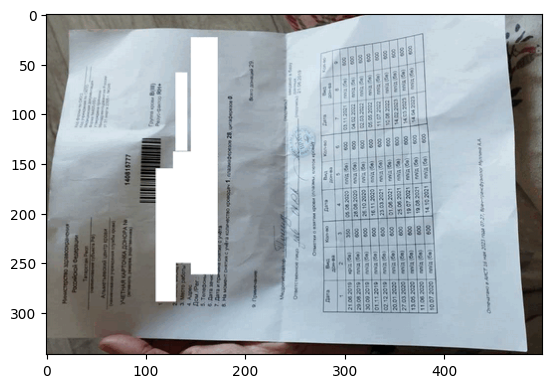

In [31]:
plt.imshow(Image.open(img_path/'405___f4017a90266440fbaef5915df90736df.png'))

__main__ 2024-10-02 19:05:28,128 INFO recognition completed


3


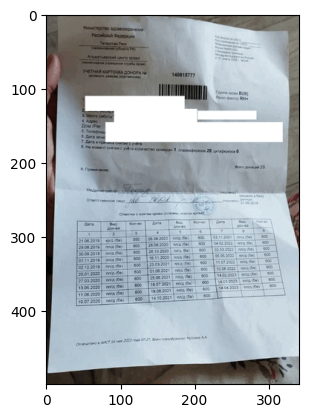

In [47]:
MEAN = [1.3638, 1.5033, 1.6996]
STD = [1.0195, 1.0658, 1.0899]
img, cls, status = evaluate_image(img_path/'405___f4017a90266440fbaef5915df90736df.png', model, mean=MEAN, std=STD)
print(cls)
plt.imshow(img);